In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses
from keras.datasets import mnist

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import os
import pickle
import numpy as np

import isolearn.io as isoio
import isolearn.keras as isol

import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from sequence_logo_helper import dna_letter_at, plot_dna_logo

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))


Using TensorFlow backend.


In [2]:
#Define dataset/experiment name
dataset_name = "apa_doubledope"

#Load cached dataframe
cached_dict = pickle.load(open('apa_doubledope_cached_set.pickle', 'rb'))
data_df = cached_dict['data_df']

print("len(data_df) = " + str(len(data_df)) + " (loaded)")


len(data_df) = 34748 (loaded)


In [3]:
#Make generators

valid_set_size = 0.05
test_set_size = 0.05

batch_size = 32

#Generate training and test set indexes
data_index = np.arange(len(data_df), dtype=np.int)

train_index = data_index[:-int(len(data_df) * (valid_set_size + test_set_size))]
valid_index = data_index[train_index.shape[0]:-int(len(data_df) * test_set_size)]
test_index = data_index[train_index.shape[0] + valid_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Validation set size = ' + str(valid_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))


data_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {'df' : data_df},
        batch_size=batch_size,
        inputs = [
            {
                'id' : 'seq',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : iso.SequenceExtractor('padded_seq', start_pos=180, end_pos=180 + 205),
                'encoder' : iso.OneHotEncoder(seq_length=205),
                'dim' : (1, 205, 4),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'hairpin',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['proximal_usage'],
                'transformer' : lambda t: t,
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [],
        shuffle = True if gen_id == 'train' else False
    ) for gen_id, idx in [('all', data_index), ('train', train_index), ('valid', valid_index), ('test', test_index)]
}


Training set size = 31274
Validation set size = 1737
Test set size = 1737


In [4]:
#Load data matrices

x_train = np.concatenate([data_gens['train'][i][0][0] for i in range(len(data_gens['train']))], axis=0)
x_test = np.concatenate([data_gens['test'][i][0][0] for i in range(len(data_gens['test']))], axis=0)

y_train = np.concatenate([data_gens['train'][i][1][0] for i in range(len(data_gens['train']))], axis=0)
y_test = np.concatenate([data_gens['test'][i][1][0] for i in range(len(data_gens['test']))], axis=0)

print("x_train.shape = " + str(x_train.shape))
print("x_test.shape = " + str(x_test.shape))

print("y_train.shape = " + str(y_train.shape))
print("y_test.shape = " + str(y_test.shape))


x_train.shape = (31264, 1, 205, 4)
x_test.shape = (1728, 1, 205, 4)
y_train.shape = (31264, 1)
y_test.shape = (1728, 1)


In [5]:
#Define sequence template (APA Doubledope sublibrary)

#sequence_template = 'CTTCCGATCTNNNNNNNNNNNNNNNNNNNNCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAC'
sequence_template = 'CTTCCGATCTNNNNNNNNNNNNNNNNNNNNCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNANTAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAC'

sequence_mask = np.array([1 if sequence_template[j] == 'N' else 0 for j in range(len(sequence_template))])


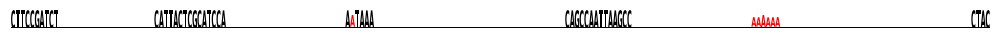

In [6]:
#Visualize background sequence distribution

save_figs = True

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 1)) + pseudo_count) / (x_train.shape[0] + 4. * pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))

plot_dna_logo(np.copy(x_mean), sequence_template=sequence_template, figsize=(14, 0.65), logo_height=1.0, plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name="benchmark_inclusion_" + dataset_name + "_background")


In [8]:
#Calculate mean training set conservation

entropy = np.sum(x_mean * -np.log(x_mean), axis=-1) / np.log(2.0)
conservation = 2.0 - entropy

x_mean_conservation = np.sum(conservation) / np.sum(sequence_mask)

print("Mean conservation (bits) = " + str(x_mean_conservation))


Mean conservation (bits) = 0.6565137658625156


In [9]:
#Calculate mean training set kl-divergence against background

x_train_clipped = np.clip(np.copy(x_train[:, 0, :, :]), 1e-8, 1. - 1e-8)

kl_divs = np.sum(x_train_clipped * np.log(x_train_clipped / np.tile(np.expand_dims(x_mean, axis=0), (x_train_clipped.shape[0], 1, 1))), axis=-1) / np.log(2.0)

x_mean_kl_divs = np.sum(kl_divs * sequence_mask, axis=-1) / np.sum(sequence_mask)
x_mean_kl_div = np.mean(x_mean_kl_divs)

print("Mean KL Div against background (bits) = " + str(x_mean_kl_div))


Mean KL Div against background (bits) = 1.872963914852614


In [10]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]

#Gumbel Distribution Sampler
def gumbel_softmax(logits, temperature=0.5) :
    gumbel_dist = tf.contrib.distributions.RelaxedOneHotCategorical(temperature, logits=logits)
    batch_dim = logits.get_shape().as_list()[0]
    onehot_dim = logits.get_shape().as_list()[1]
    return gumbel_dist.sample()


In [11]:
#PWM Masking and Sampling helper functions

def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

def sample_pwm_st(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = st_sampled_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

def sample_pwm_gumbel(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, 4))
    sampled_pwm = gumbel_softmax(flat_pwm, temperature=0.5)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, 4))

#Generator helper functions
def initialize_sequence_templates(generator, sequence_templates, background_matrices) :

    embedding_templates = []
    embedding_masks = []
    embedding_backgrounds = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = iso.OneHotEncoder(seq_length=len(sequence_template))(sequence_template).reshape((1, len(sequence_template), 4))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['N', 'X'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0
            elif sequence_template[j] == 'X' :
                onehot_template[:, j, :] = -1.0

        onehot_mask = np.zeros((1, len(sequence_template), 4))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == 'N' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))
        embedding_backgrounds.append(background_matrices[k].reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)
    embedding_backgrounds = np.concatenate(embedding_backgrounds, axis=0)

    generator.get_layer('template_dense').set_weights([embedding_templates])
    generator.get_layer('template_dense').trainable = False

    generator.get_layer('mask_dense').set_weights([embedding_masks])
    generator.get_layer('mask_dense').trainable = False
    
    generator.get_layer('background_dense').set_weights([embedding_backgrounds])
    generator.get_layer('background_dense').trainable = False

#Generator construction function
def build_sampler(batch_size, seq_length, n_classes=1, n_samples=1, sample_mode='st') :

    #Initialize Reshape layer
    reshape_layer = Reshape((1, seq_length, 4))
    
    #Initialize background matrix
    onehot_background_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='background_dense')

    #Initialize template and mask matrices
    onehot_template_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='template_dense')
    onehot_mask_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='ones', name='mask_dense')

    #Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(mask_pwm, output_shape = (1, seq_length, 4), name='masking_layer')
    background_layer = Lambda(lambda x: x[0] + x[1], name='background_layer')
    
    #Initialize PWM normalization layer
    pwm_layer = Softmax(axis=-1, name='pwm')
    
    #Initialize sampling layers
    sample_func = None
    if sample_mode == 'st' :
        sample_func = sample_pwm_st
    elif sample_mode == 'gumbel' :
        sample_func = sample_pwm_gumbel
    
    upsampling_layer = Lambda(lambda x: K.tile(x, [n_samples, 1, 1, 1]), name='upsampling_layer')
    sampling_layer = Lambda(sample_func, name='pwm_sampler')
    permute_layer = Lambda(lambda x: K.permute_dimensions(K.reshape(x, (n_samples, batch_size, 1, seq_length, 4)), (1, 0, 2, 3, 4)), name='permute_layer')
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        onehot_background = reshape_layer(onehot_background_dense(class_input))
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm_logits = masking_layer([background_layer([raw_logits, onehot_background]), onehot_template, onehot_mask])
        
        #Compute PWM (Nucleotide-wise Softmax)
        pwm = pwm_layer(pwm_logits)
        
        #Tile each PWM to sample from and create sample axis
        pwm_logits_upsampled = upsampling_layer(pwm_logits)
        sampled_pwm = sampling_layer(pwm_logits_upsampled)
        sampled_pwm = permute_layer(sampled_pwm)

        sampled_mask = permute_layer(upsampling_layer(onehot_mask))
        
        return pwm_logits, pwm, sampled_pwm, onehot_mask, sampled_mask
    
    return _sampler_func


In [12]:
#Initialize Encoder and Decoder networks
batch_size = 32
seq_length = 205
n_samples = 128
sample_mode = 'st'
#sample_mode = 'gumbel'

#Load sampler
sampler = build_sampler(batch_size, seq_length, n_classes=1, n_samples=n_samples, sample_mode=sample_mode)


In [13]:
#Load Predictor
predictor_path = '../../../aparent/saved_models/aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'

predictor = load_model(predictor_path)

predictor.trainable = False
predictor.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [14]:
#Build scrambler model
dummy_class = Input(shape=(1,), name='dummy_class')
input_logits = Input(shape=(1, seq_length, 4), name='input_logits')

pwm_logits, pwm, sampled_pwm, pwm_mask, sampled_mask = sampler(dummy_class, input_logits)

scrambler_model = Model([input_logits, dummy_class], [pwm_logits, pwm, sampled_pwm, pwm_mask, sampled_mask])

#Initialize Sequence Templates and Masks
initialize_sequence_templates(scrambler_model, [sequence_template], [x_mean_logits])

scrambler_model.trainable = False
scrambler_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)


In [15]:
scrambler_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dummy_class (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
background_dense (Embedding)    (None, 1, 820)       820         dummy_class[0][0]                
__________________________________________________________________________________________________
input_logits (InputLayer)       (None, 1, 205, 4)    0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, 205, 4)    0           background_dense[0][0]           
                                                                 template_dense[0][0]             
          

In [18]:

file_names = [
    "autoscrambler_dataset_apa_doubledope_sample_mode_st_n_samples_32_resnet_1_4_32_8_025_n_epochs_50_target_bits_025_importance_scores_test.npy",
    "perturbation_apa_doubledope_importance_scores_test.npy",
    "deepexplain_apa_doubledope_method_gradient_importance_scores_test.npy",
    "deepexplain_apa_doubledope_method_integrated_gradients_importance_scores_test.npy",
    "deepexplain_apa_doubledope_method_rescale_importance_scores_test.npy",
    "deepshap_apa_doubledope_importance_scores_test.npy",
    "extremal_apa_doubledope_mode_preserve_importance_scores_test.npy"
]

model_names =[
    "scrambler",
    "perturbation",
    "gradient",
    "integrated_gradients",
    "deeplift",
    "deepshap",
    "extremal"
]

model_importance_scores_test = [np.load(file_name) for file_name in file_names]

for model_i in range(len(model_names)) :
    if model_importance_scores_test[model_i].shape[-1] > 1 :
        model_importance_scores_test[model_i] = np.sum(model_importance_scores_test[model_i], axis=-1, keepdims=True)


In [19]:

feature_quantiles = [0.80, 0.90, 0.95, 0.98]

on_state_logit_val = 50.

dummy_test = np.zeros((x_test.shape[0], 1))
x_test_logits = 2. * x_test - 1.

aparent_l_test = np.zeros((x_test.shape[0], 13))
aparent_l_test[:, 4] = 1.

aparent_d_test = np.ones((x_test.shape[0], 1))

y_pred_ref = predictor.predict([np.transpose(x_test, (0, 2, 3, 1)), aparent_l_test, aparent_d_test], batch_size=32, verbose=True)[0]

_, _, _, pwm_mask, sampled_mask = scrambler_model.predict([x_test_logits, dummy_test], batch_size=batch_size)

model_kl_divergences = []

for model_i in range(len(model_names)) :
    
    print("Benchmarking model '" + str(model_names[model_i]) + "'...")
    
    feature_quantile_kl_divergences = []
    
    for feature_quantile_i, feature_quantile in enumerate(feature_quantiles) :
        
        print("Feature quantile = " + str(feature_quantile))
    
        if len(model_importance_scores_test[model_i].shape) >= 5 :
            importance_scores_test = np.abs(model_importance_scores_test[model_i][feature_quantile_i, ...])
        else :
            importance_scores_test = np.abs(model_importance_scores_test[model_i])
        
        n_to_test = importance_scores_test.shape[0] // batch_size * batch_size
        importance_scores_test = importance_scores_test[:n_to_test]
        
        importance_scores_test *= np.expand_dims(np.max(pwm_mask[:n_to_test], axis=-1), axis=-1)

        quantile_vals = np.quantile(importance_scores_test, axis=(1, 2, 3), q=feature_quantile, keepdims=True)
        quantile_vals = np.tile(quantile_vals, (1, importance_scores_test.shape[1], importance_scores_test.shape[2], importance_scores_test.shape[3]))

        top_logits_test = np.zeros(importance_scores_test.shape)
        top_logits_test[importance_scores_test > quantile_vals] = on_state_logit_val
        
        top_logits_test = np.tile(top_logits_test, (1, 1, 1, 4)) * x_test_logits[:n_to_test]

        _, _, samples_test, _, _ = scrambler_model.predict([top_logits_test, dummy_test[:n_to_test]], batch_size=batch_size)

        mean_kl_divs = []
        for data_ix in range(samples_test.shape[0]) :

            if data_ix % 100 == 0 :
                print("Processing example " + str(data_ix) + "...")

            y_pred_var_samples = predictor.predict([np.transpose(samples_test[data_ix, ...], (0, 2, 3, 1)), aparent_l_test[:n_samples], aparent_d_test[:n_samples]], batch_size=n_samples)[0][:, 0]
            y_pred_ref_samples = np.tile(y_pred_ref[data_ix, :], (n_samples,))
            
            y_pred_var_samples = np.clip(y_pred_var_samples, 1e-6, 1. - 1e-6)
            y_pred_ref_samples = np.clip(y_pred_ref_samples, 1e-6, 1. - 1e-6)

            left_kl_divs = y_pred_ref_samples * np.log(y_pred_ref_samples / y_pred_var_samples) + (1. - y_pred_ref_samples) * np.log((1. - y_pred_ref_samples) / (1. - y_pred_var_samples))
            right_kl_divs = y_pred_var_samples * np.log(y_pred_var_samples / y_pred_ref_samples) + (1. - y_pred_var_samples) * np.log((1. - y_pred_var_samples) / (1. - y_pred_ref_samples))
            
            mean_kl_div = np.mean(left_kl_divs + right_kl_divs)

            mean_kl_divs.append(mean_kl_div)

        mean_kl_divs = np.array(mean_kl_divs)
        
        feature_quantile_kl_divergences.append(mean_kl_divs)

    model_kl_divergences.append(feature_quantile_kl_divergences)


1728/1728 [==============================] - 0s 71us/step
Benchmarking model 'scrambler'...
Feature quantile = 0.8
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 1400...
Processing example 1500...
Processing example 1600...
Processing example 1700...
Feature quantile = 0.9
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 140

Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 1400...
Processing example 1500...
Processing example 1600...
Processing example 1700...
Feature quantile = 0.9
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 1400...
Processing example 1500...
Processing example 1600...
Processing example 1700...
Feature quantile = 0.95
Proce

In [20]:
model_names =[
    "scrambler",
    "perturbation",
    "gradient",
    "integrated\ngradients",
    "deeplift",
    "deepshap",
    "extremal"
]

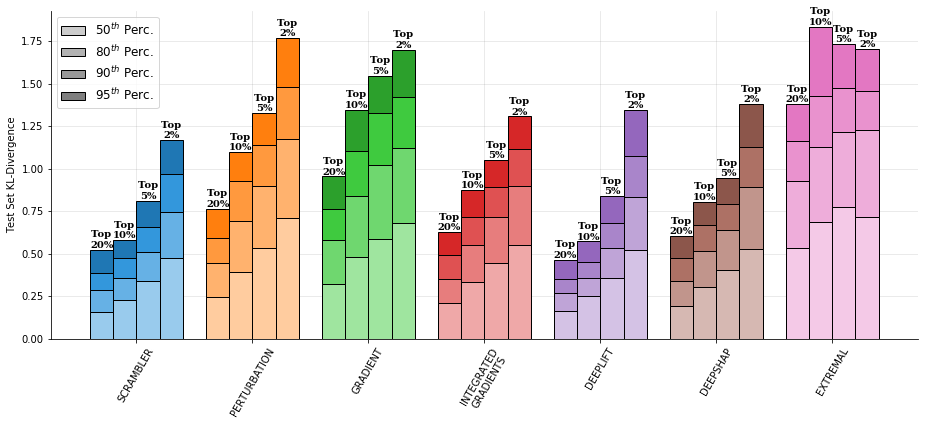

In [21]:
def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

fig = plt.figure(figsize=(13, 6))

benchmark_name = "benchmark_inclusion_apa_doubledope"

save_figs = True

width = 0.2

max_y_val = None

cm = plt.get_cmap('viridis_r')

shades = [0.4, 0.6, 0.8, 1]

quantiles = [0.5, 0.8, 0.9, 0.95]

all_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + plt.rcParams['axes.prop_cycle'].by_key()['color']
model_colors = {model_names[i]: all_colors[i] for i in range(len(model_names))}

results = np.zeros((len(quantiles), len(model_names), 1))

for i in range(1, len(feature_quantiles) + 1) :
    for j in range(len(model_names)):
        kl_div_samples = model_kl_divergences[j][i-1]

        for l in range(len(quantiles)):
            quantile = quantiles[l]

            results[l, j, 0] = np.quantile(kl_div_samples, q=quantile)

    xs = range(len(model_names))
    xs = [xi + i*width for xi in xs]
    
    for j in range(len(model_names)) :
        for l in range(len(quantiles)) :
            model_name = model_names[j]
            c = model_colors[model_name]
            val = results[l, j, 0]
            
            if i == 1 and j == 0 :
                lbl = "$%i^{th}$ Perc." % int(100*quantiles[l])
            else :
                lbl=None
            
            if l == 0 :
                plt.bar(xs[j], val, width=width, color=lighten_color(c, shades[l]), edgecolor='k', linewidth=1, label=lbl, zorder=l+1)
            else :
                prev_val = results[l-1, j].mean(axis=-1)
                plt.bar(xs[j],val-prev_val, width=width, bottom = prev_val, color=lighten_color(c, shades[l]), edgecolor='k', linewidth=1, label=lbl, zorder=l+1)
    
            if l == len(quantiles) - 1 and (max_y_val is None or val < 0.95 * max_y_val) :
                plt.text(xs[j], val, "Top\n" + str(int(100 - 100 * feature_quantiles[i-1])) + "%", horizontalalignment='center', verticalalignment='bottom', fontdict={ 'family': 'serif', 'color':  'black', 'weight': 'bold', 'size': 10 })
    
    prev_results = results

plt.xticks([i + 2.5*width for i in range(len(model_names))])

all_lbls = [model_names[j].upper() for j in range(len(model_names))]
plt.gca().set_xticklabels(all_lbls, rotation=60)

plt.ylabel("Test Set KL-Divergence")

#max_y_val = np.max(results) * 1.1

if max_y_val is not None :
    plt.ylim([0, max_y_val])

plt.grid(True)
plt.gca().set_axisbelow(True)
plt.gca().grid(color='gray', alpha=0.2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.legend(fontsize=12, frameon=True, loc='upper left')
leg = plt.gca().get_legend()
for l in range(len(quantiles)):
    leg.legendHandles[l].set_color(lighten_color(all_colors[7], shades[l]))
    leg.legendHandles[l].set_edgecolor('k')

plt.tight_layout()

if save_figs :
    plt.savefig(benchmark_name + ".png", dpi=300, transparent=True)
    plt.savefig(benchmark_name + ".eps")

plt.show()


In [22]:

feature_quantiles = [0.80, 0.90, 0.95, 0.98]

on_state_logit_val = 50.

dummy_test = np.zeros((x_test.shape[0], 1))
x_test_logits = 2. * x_test - 1.

aparent_l_test = np.zeros((x_test.shape[0], 13))
aparent_l_test[:, 4] = 1.

aparent_d_test = np.ones((x_test.shape[0], 1))

y_pred_ref = predictor.predict([np.transpose(x_test, (0, 2, 3, 1)), aparent_l_test, aparent_d_test], batch_size=32, verbose=True)[0]

_, _, _, pwm_mask, sampled_mask = scrambler_model.predict([x_test_logits, dummy_test], batch_size=batch_size)

model_kl_divergences = []

for model_i in range(len(model_names)) :
    
    print("Benchmarking model '" + str(model_names[model_i]) + "'...")
    
    feature_quantile_kl_divergences = []
    
    for feature_quantile_i, feature_quantile in enumerate(feature_quantiles) :
        
        print("Feature quantile = " + str(feature_quantile))
    
        if len(model_importance_scores_test[model_i].shape) >= 5 :
            importance_scores_test = np.abs(model_importance_scores_test[model_i][feature_quantile_i, ...])
        else :
            importance_scores_test = np.abs(model_importance_scores_test[model_i])
        
        n_to_test = importance_scores_test.shape[0] // batch_size * batch_size
        importance_scores_test = importance_scores_test[:n_to_test]
        
        importance_scores_test *= np.expand_dims(np.max(pwm_mask[:n_to_test], axis=-1), axis=-1)

        quantile_vals = np.quantile(importance_scores_test, axis=(1, 2, 3), q=feature_quantile, keepdims=True)
        quantile_vals = np.tile(quantile_vals, (1, importance_scores_test.shape[1], importance_scores_test.shape[2], importance_scores_test.shape[3]))

        top_logits_test = np.zeros(importance_scores_test.shape)
        top_logits_test[importance_scores_test > quantile_vals] = on_state_logit_val
        
        top_logits_test = np.tile(top_logits_test, (1, 1, 1, 4)) * x_test_logits[:n_to_test]

        _, _, samples_test, _, _ = scrambler_model.predict([top_logits_test, dummy_test[:n_to_test]], batch_size=batch_size)

        mean_kl_divs = []
        for data_ix in range(samples_test.shape[0]) :

            if data_ix % 100 == 0 :
                print("Processing example " + str(data_ix) + "...")

            y_pred_var_samples = predictor.predict([np.transpose(samples_test[data_ix, ...], (0, 2, 3, 1)), aparent_l_test[:n_samples], aparent_d_test[:n_samples]], batch_size=n_samples)[0][:, 0]
            y_pred_ref_samples = np.tile(y_pred_ref[data_ix, :], (n_samples,))
            
            y_pred_var_samples = np.clip(y_pred_var_samples, 1e-6, 1. - 1e-6)
            y_pred_ref_samples = np.clip(y_pred_ref_samples, 1e-6, 1. - 1e-6)
            
            y_pred_var_samples = np.log(y_pred_var_samples / (1. - y_pred_var_samples))
            y_pred_ref_samples = np.log(y_pred_ref_samples / (1. - y_pred_ref_samples))

            y_pred_var_samples = np.clip(y_pred_var_samples, -10., 10.)
            y_pred_ref_samples = np.clip(y_pred_ref_samples, -10., 10.)

            kl_divs = np.maximum(np.sign(y_pred_ref_samples) * (y_pred_ref_samples - y_pred_var_samples), 0.)
            mean_kl_div = np.mean(kl_divs)

            mean_kl_divs.append(mean_kl_div)

        mean_kl_divs = np.array(mean_kl_divs)
        
        feature_quantile_kl_divergences.append(mean_kl_divs)

    model_kl_divergences.append(feature_quantile_kl_divergences)


1728/1728 [==============================] - 0s 127us/step
Benchmarking model 'scrambler'...
Feature quantile = 0.8
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 1400...
Processing example 1500...
Processing example 1600...
Processing example 1700...
Feature quantile = 0.9
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 14

Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 1400...
Processing example 1500...
Processing example 1600...
Processing example 1700...
Feature quantile = 0.9
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 1400...
Processing example 1500...
Processing example 1600...
Processing example 1700...
Feature quantile = 0.95
Proce

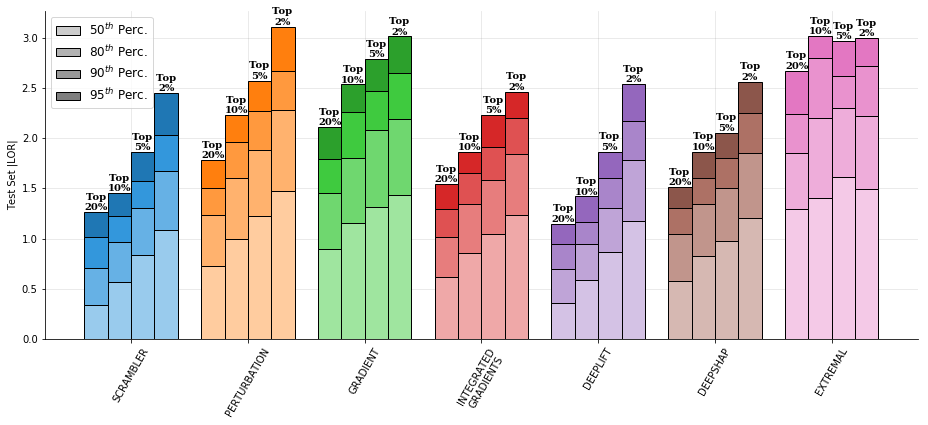

In [23]:
def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

fig = plt.figure(figsize=(13, 6))

benchmark_name = "benchmark_inclusion_apa_doubledope"

save_figs = True

width = 0.2

max_y_val = None

cm = plt.get_cmap('viridis_r')

shades = [0.4, 0.6, 0.8, 1]

quantiles = [0.5, 0.8, 0.9, 0.95]

all_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + plt.rcParams['axes.prop_cycle'].by_key()['color']
model_colors = {model_names[i]: all_colors[i] for i in range(len(model_names))}

results = np.zeros((len(quantiles), len(model_names), 1))

for i in range(1, len(feature_quantiles) + 1) :
    for j in range(len(model_names)):
        kl_div_samples = model_kl_divergences[j][i-1]

        for l in range(len(quantiles)):
            quantile = quantiles[l]

            results[l, j, 0] = np.quantile(kl_div_samples, q=quantile)

    xs = range(len(model_names))
    xs = [xi + i*width for xi in xs]
    
    for j in range(len(model_names)) :
        for l in range(len(quantiles)) :
            model_name = model_names[j]
            c = model_colors[model_name]
            val = results[l, j, 0]
            
            if i == 1 and j == 0 :
                lbl = "$%i^{th}$ Perc." % int(100*quantiles[l])
            else :
                lbl=None
            
            if l == 0 :
                plt.bar(xs[j], val, width=width, color=lighten_color(c, shades[l]), edgecolor='k', linewidth=1, label=lbl, zorder=l+1)
            else :
                prev_val = results[l-1, j].mean(axis=-1)
                plt.bar(xs[j],val-prev_val, width=width, bottom = prev_val, color=lighten_color(c, shades[l]), edgecolor='k', linewidth=1, label=lbl, zorder=l+1)
    
            if l == len(quantiles) - 1 and (max_y_val is None or val < 0.95 * max_y_val) :
                plt.text(xs[j], val, "Top\n" + str(int(100 - 100 * feature_quantiles[i-1])) + "%", horizontalalignment='center', verticalalignment='bottom', fontdict={ 'family': 'serif', 'color':  'black', 'weight': 'bold', 'size': 10 })
    
    prev_results = results

plt.xticks([i + 2.5*width for i in range(len(model_names))])

all_lbls = [model_names[j].upper() for j in range(len(model_names))]
plt.gca().set_xticklabels(all_lbls, rotation=60)

plt.ylabel("Test Set |LOR|")

#max_y_val = np.max(results) * 1.1

if max_y_val is not None :
    plt.ylim([0, max_y_val])

plt.grid(True)
plt.gca().set_axisbelow(True)
plt.gca().grid(color='gray', alpha=0.2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.legend(fontsize=12, frameon=True, loc='upper left')
leg = plt.gca().get_legend()
for l in range(len(quantiles)):
    leg.legendHandles[l].set_color(lighten_color(all_colors[7], shades[l]))
    leg.legendHandles[l].set_edgecolor('k')

plt.tight_layout()

if save_figs :
    plt.savefig(benchmark_name + "_log_odds_ratio" + ".png", dpi=300, transparent=True)
    plt.savefig(benchmark_name + "_log_odds_ratio" + ".eps")

plt.show()


In [25]:
#Gradient saliency/backprop visualization

import matplotlib.collections as collections
import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def plot_importance_scores(importance_scores, ref_seq, figsize=(12, 2), score_clip=None, sequence_template='', plot_start=0, plot_end=96, plot_sequence_template=False, save_figs=False, fig_name=None) :

    end_pos = ref_seq.find("#")
    
    fig = plt.figure(figsize=figsize)
    
    ax = plt.gca()
    
    if score_clip is not None :
        importance_scores = np.clip(np.copy(importance_scores), -score_clip, score_clip)
    
    max_score = np.max(np.sum(importance_scores[:, :], axis=0)) + 0.01

    for i in range(0, len(ref_seq)) :
        if sequence_template[i] == 'N' :
            mutability_score = np.sum(importance_scores[:, i])
            dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax)
        elif plot_sequence_template :
            dna_letter_at(ref_seq[i], i + 0.5, 0, max_score, ax, color='black')

    plt.sca(ax)
    plt.xlim((0, len(ref_seq)))
    plt.ylim((0, max_score))
    plt.axis('off')
    #plt.yticks([0.0, max_score], [0.0, max_score], fontsize=16)
    
    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()


1728/1728 [==============================] - 0s 85us/step
Test pattern = 3:
 - Prediction (original) = 0.15


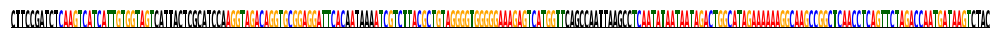

Model = 'scrambler'...
 - Prediction (scrambled qts) = ['0.35', '0.28', '0.32', '0.34']
 - Prediction (scrambled natural) = 0.33


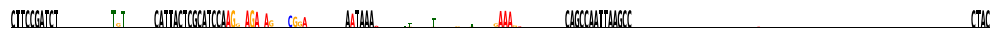

Model = 'perturbation'...
 - Prediction (scrambled qts) = ['0.43', '0.57', '0.48', '0.45']


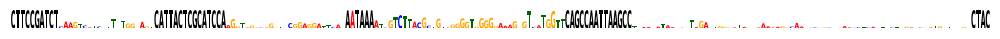

Model = 'gradient'...
 - Prediction (scrambled qts) = ['0.56', '0.48', '0.59', '0.44']


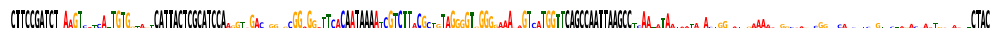

Model = 'integrated_gradients'...
 - Prediction (scrambled qts) = ['0.3', '0.32', '0.43', '0.43']


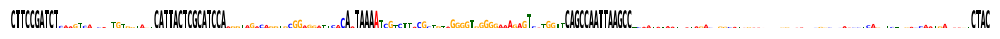

Model = 'deeplift'...
 - Prediction (scrambled qts) = ['0.23', '0.45', '0.49', '0.56']


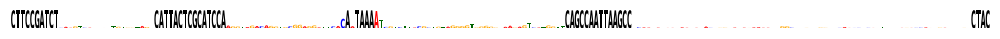

Model = 'deepshap'...
 - Prediction (scrambled qts) = ['0.66', '0.73', '0.59', '0.49']


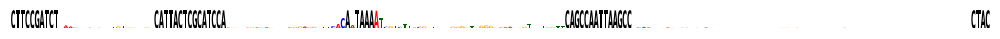

Model = 'extremal'...
 - Prediction (scrambled qts) = ['0.34', '0.37', '0.37', '0.39']


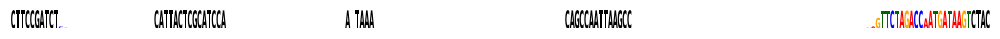

Test pattern = 4:
 - Prediction (original) = 0.27


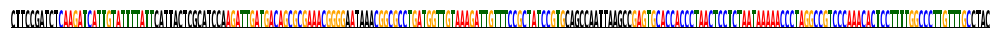

Model = 'scrambler'...
 - Prediction (scrambled qts) = ['0.14', '0.32', '0.42', '0.33']
 - Prediction (scrambled natural) = 0.23


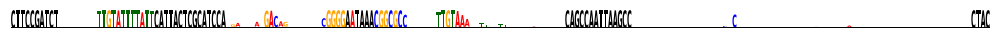

Model = 'perturbation'...
 - Prediction (scrambled qts) = ['0.32', '0.43', '0.39', '0.45']


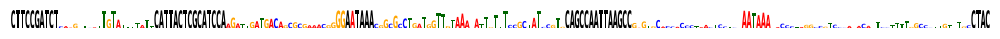

Model = 'gradient'...
 - Prediction (scrambled qts) = ['0.35', '0.35', '0.48', '0.57']


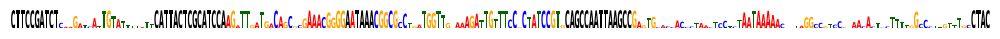

Model = 'integrated_gradients'...
 - Prediction (scrambled qts) = ['0.17', '0.42', '0.46', '0.49']


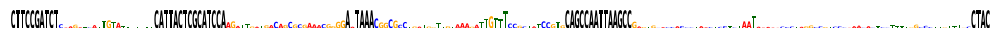

Model = 'deeplift'...
 - Prediction (scrambled qts) = ['0.29', '0.32', '0.39', '0.37']


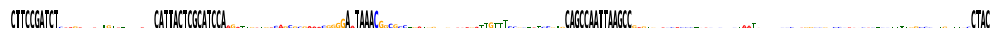

Model = 'deepshap'...
 - Prediction (scrambled qts) = ['0.48', '0.36', '0.34', '0.21']


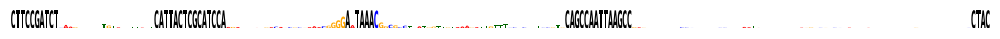

Model = 'extremal'...
 - Prediction (scrambled qts) = ['0.19', '0.24', '0.38', '0.38']


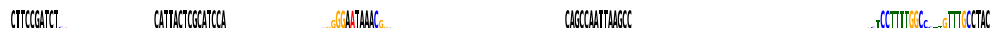

Test pattern = 6:
 - Prediction (original) = 0.93


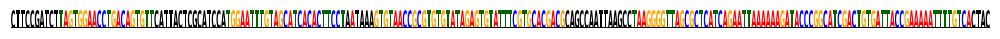

Model = 'scrambler'...
 - Prediction (scrambled qts) = ['0.93', '0.86', '0.76', '0.54']
 - Prediction (scrambled natural) = 0.92


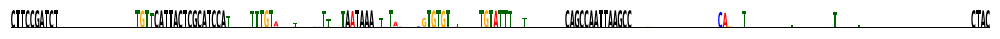

Model = 'perturbation'...
 - Prediction (scrambled qts) = ['0.91', '0.84', '0.79', '0.52']


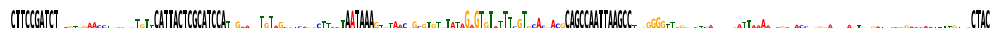

Model = 'gradient'...
 - Prediction (scrambled qts) = ['0.81', '0.68', '0.59', '0.46']


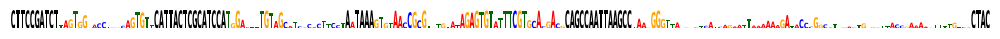

Model = 'integrated_gradients'...
 - Prediction (scrambled qts) = ['0.72', '0.63', '0.74', '0.63']


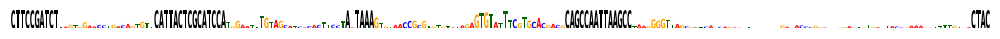

Model = 'deeplift'...
 - Prediction (scrambled qts) = ['0.78', '0.88', '0.84', '0.58']


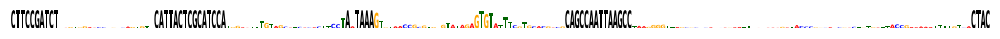

Model = 'deepshap'...
 - Prediction (scrambled qts) = ['0.94', '0.86', '0.77', '0.57']


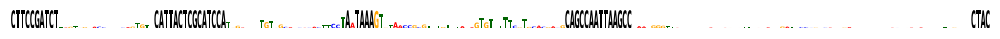

Model = 'extremal'...
 - Prediction (scrambled qts) = ['0.43', '0.54', '0.42', '0.42']


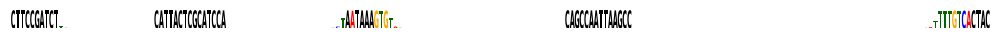

Test pattern = 7:
 - Prediction (original) = 0.84


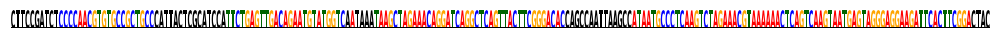

Model = 'scrambler'...
 - Prediction (scrambled qts) = ['0.69', '0.66', '0.67', '0.49']
 - Prediction (scrambled natural) = 0.61


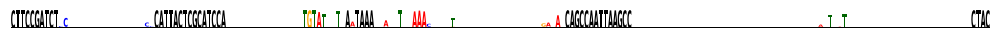

Model = 'perturbation'...
 - Prediction (scrambled qts) = ['0.83', '0.81', '0.72', '0.65']


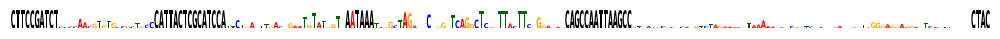

Model = 'gradient'...
 - Prediction (scrambled qts) = ['0.62', '0.49', '0.33', '0.47']


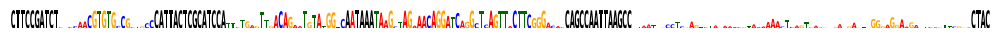

Model = 'integrated_gradients'...
 - Prediction (scrambled qts) = ['0.69', '0.53', '0.62', '0.47']


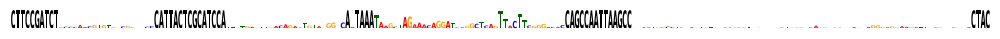

Model = 'deeplift'...
 - Prediction (scrambled qts) = ['0.61', '0.71', '0.61', '0.49']


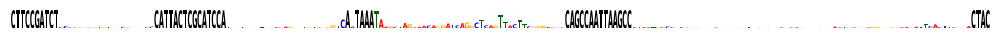

Model = 'deepshap'...
 - Prediction (scrambled qts) = ['0.76', '0.78', '0.69', '0.54']


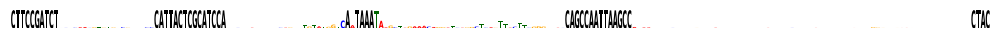

Model = 'extremal'...
 - Prediction (scrambled qts) = ['0.38', '0.4', '0.39', '0.36']


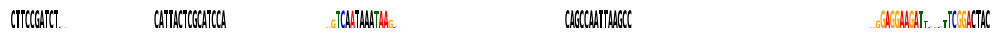

In [26]:
#Visualize a few example patterns

save_figs = True

plot_examples = [3, 4, 6, 7]

feature_quantiles = [0.80, 0.90, 0.95, 0.98]

score_clips = [
    None,
    0.5,
    0.5,
    0.5,
    0.5,
    0.5,
    0.5
]

on_state_logit_val = 50.

encoder = isol.OneHotEncoder(205)

dummy_test = np.zeros((x_test.shape[0], 1))
x_test_logits = 2. * x_test - 1.

aparent_l_test = np.zeros((x_test.shape[0], 13))
aparent_l_test[:, 4] = 1.

aparent_d_test = np.ones((x_test.shape[0], 1))

y_pred_ref = predictor.predict([np.transpose(x_test, (0, 2, 3, 1)), aparent_l_test, aparent_d_test], batch_size=32, verbose=True)[0]

_, _, _, pwm_mask, sampled_mask = scrambler_model.predict([x_test_logits, dummy_test], batch_size=batch_size)

for data_ix in plot_examples :
    
    print("Test pattern = " + str(data_ix) + ":")

    y_test_hat_ref = predictor.predict(x=[np.expand_dims(np.expand_dims(x_test[data_ix, 0, :, :], axis=0), axis=-1), aparent_l_test[:1], aparent_d_test[:1]], batch_size=1)[0][0, 0]
    
    print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
    
    plot_dna_logo(x_test[data_ix, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name="benchmark_inclusion_" + dataset_name + "_test_ix_" + str(data_ix))
    
    for model_i in range(len(model_names)) :

        print("Model = '" + str(model_names[model_i]) + "'...")

        if len(model_importance_scores_test[model_i].shape) >= 5 :
            importance_scores_test = np.abs(model_importance_scores_test[model_i][1, ...])
        else :
            importance_scores_test = np.abs(model_importance_scores_test[model_i])
        
        importance_scores_test = importance_scores_test[:32]
        importance_scores_test *= np.expand_dims(np.max(pwm_mask[:32], axis=-1), axis=-1)
        
        y_test_hat_mean_qts = []
        for feature_quantile_i, feature_quantile in enumerate(feature_quantiles) :

            quantile_vals = np.quantile(importance_scores_test, axis=(1, 2, 3), q=feature_quantile, keepdims=True)
            quantile_vals = np.tile(quantile_vals, (1, importance_scores_test.shape[1], importance_scores_test.shape[2], importance_scores_test.shape[3]))

            top_logits_test = np.zeros(importance_scores_test.shape)
            top_logits_test[importance_scores_test > quantile_vals] = on_state_logit_val

            top_logits_test = np.tile(top_logits_test, (1, 1, 1, 4)) * x_test_logits[:32]

            _, _, samples_test, _, _ = scrambler_model.predict([top_logits_test, dummy_test[:32]], batch_size=batch_size)

            y_test_hat = predictor.predict(x=[np.expand_dims(samples_test[data_ix, :, 0, :, :], axis=-1), aparent_l_test[:n_samples], aparent_d_test[:n_samples]], batch_size=32)[0][:, 0]
            y_test_hat_mean = np.mean(y_test_hat)

            y_test_hat_mean_qts.append(str(round(y_test_hat_mean, 2))[:4])

        print(" - Prediction (scrambled qts) = " + str(y_test_hat_mean_qts))
        
        if 'scrambler' in model_names[model_i] :
            
            scrambled_logits_test = np.tile(importance_scores_test[:32], (1, 1, 1, 4)) * x_test_logits[:32]
            
            _, pwm_test, samples_test, _, _ = scrambler_model.predict_on_batch([scrambled_logits_test, dummy_test[:32]])

            y_test_hat = predictor.predict(x=[np.expand_dims(samples_test[data_ix, :, 0, :, :], axis=-1), aparent_l_test[:n_samples], aparent_d_test[:n_samples]], batch_size=32)[0][:, 0]
            y_test_hat_mean = np.mean(y_test_hat)

            print(" - Prediction (scrambled natural) = " + str(round(y_test_hat_mean, 2))[:4])
            
            subtracted_pwm_test = np.exp(scrambled_logits_test) / np.sum(np.exp(scrambled_logits_test), axis=-1, keepdims=True)

            plot_dna_logo(subtracted_pwm_test[data_ix, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name="benchmark_inclusion_" + dataset_name + "_test_ix_" + str(data_ix) + "_" + model_names[model_i])
        
        else :
            
            plot_importance_scores(importance_scores_test[data_ix, 0, :, :].T, encoder.decode(x_test[data_ix, 0, :, :]), figsize=(14, 0.65), score_clip=score_clips[model_i], sequence_template=sequence_template, plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name="benchmark_inclusion_" + dataset_name + "_test_ix_" + str(data_ix) + "_" + model_names[model_i])
